# This notebook explores residual momentum, which is an enhancement to standard momentum formulation



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import getFamaFrenchFactors as gff

from finstratb.misc.helpers import get_data

## Fetching Fama-French factors

### FF factors description

* Market Risk Premium (MRP)
* Size Premium (i.e., Small minus Big) (SMB)
* Value Premium (i.e., High Book-to-Market minus Low Book-to-Market)
* The Risk-free rate (RF)

In [2]:
df_ff3_monthly = gff.famaFrench3Factor(frequency='m')

In [3]:
df_ff3_monthly

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0238,-0.0273,0.0022
1,1926-08-31,0.0264,-0.0147,0.0414,0.0025
2,1926-09-30,0.0036,-0.0139,0.0012,0.0023
3,1926-10-31,-0.0324,-0.0013,0.0065,0.0032
4,1926-11-30,0.0253,-0.0016,-0.0038,0.0031
...,...,...,...,...,...
1143,2021-10-31,0.0665,-0.0228,-0.0044,0.0000
1144,2021-11-30,-0.0155,-0.0135,-0.0053,0.0000
1145,2021-12-31,0.0310,-0.0157,0.0323,0.0001
1146,2022-01-31,-0.0624,-0.0587,0.1279,0.0000


## Transform data to suitable format

In [18]:
tickers = ['MSFT']
ticker_data = get_data(tickers)

2022-04-07 11:28:05.865 | INFO     | finstratb.misc.helpers:get_data:9 - Fetching MSFT


In [19]:
t_data = pd.DataFrame(ticker_data[tickers[0]])[['close']]

In [20]:
t_data.tail(5)

,close
date,
2022-03-31,308.309998
2022-04-01,309.420013
2022-04-04,314.970001
2022-04-05,310.880005
2022-04-06,299.500000


In [21]:
t_data_monthly = (t_data
.resample('M')
.last()
.assign(monthly_return = lambda df: df.pct_change())
.fillna(0)
.iloc[:-1] # Get rid of last observation as month isn't finished yet
)

In [22]:
factors_resampled = (df_ff3_monthly
 .set_index('date_ff_factors')
 .resample('D')
 .pad()
)

In [23]:
factors_resampled

,Mkt-RF,SMB,HML,RF
date_ff_factors,,,,
1926-07-31,0.0296,-0.0238,-0.0273,0.0022
1926-08-01,0.0296,-0.0238,-0.0273,0.0022
1926-08-02,0.0296,-0.0238,-0.0273,0.0022
1926-08-03,0.0296,-0.0238,-0.0273,0.0022
1926-08-04,0.0296,-0.0238,-0.0273,0.0022
...,...,...,...,...
2022-02-24,-0.0624,-0.0587,0.1279,0.0000
2022-02-25,-0.0624,-0.0587,0.1279,0.0000
2022-02-26,-0.0624,-0.0587,0.1279,0.0000


In [24]:
monthly_combined = (t_data_monthly
 .merge(factors_resampled, how = 'left', left_index=True, right_index=True)
 .ffill()
 .sort_index(ascending = True)
 .assign(monthly_returns_less_rf = lambda df: df['monthly_return'] - df['RF'])
)

monthly_combined.tail(12)

,close,monthly_return,Mkt-RF,SMB,HML,RF,monthly_returns_less_rf
date,,,,,,,
2021-04-30,250.142471,0.069602,0.0493,-0.0313,-0.0099,0.0000,0.069602
2021-05-31,248.234558,-0.007627,0.0029,-0.0024,0.0703,0.0000,-0.007627
2021-06-30,269.331726,0.084989,0.0275,0.0175,-0.0781,0.0000,0.084989
2021-07-31,283.260620,0.051716,0.0127,-0.0396,-0.0175,0.0000,0.051716
2021-08-31,300.706940,0.061591,0.0290,-0.0048,-0.0013,0.0000,0.061591
2021-09-30,280.824524,-0.066119,-0.0437,0.0080,0.0509,0.0000,-0.066119
2021-10-31,330.331360,0.176291,0.0665,-0.0228,-0.0044,0.0000,0.176291
2021-11-30,329.907837,-0.001282,-0.0155,-0.0135,-0.0053,0.0000,-0.001282
2021-12-31,335.626038,0.017333,0.0310,-0.0157,0.0323,0.0001,0.017233


In [25]:
monthly_combined.head()

,close,monthly_return,Mkt-RF,SMB,HML,RF,monthly_returns_less_rf
date,,,,,,,
1987-04-30,0.228184,0.000000,-0.0211,-0.0169,-0.0039,0.0044,-0.004400
1987-05-31,0.252867,0.108175,0.0011,-0.0050,0.0023,0.0038,0.104375
1987-06-30,0.223796,-0.114967,0.0394,-0.0212,0.0104,0.0048,-0.119767
1987-07-31,0.206243,-0.078432,0.0385,-0.0066,0.0073,0.0046,-0.083032
1987-08-31,0.260546,0.263296,0.0352,-0.0077,-0.0095,0.0047,0.258596


In [26]:
monthly_combined.to_csv("monthly_combined.csv")

## Regression

In [27]:
import statsmodels.api as sm
import numpy as np
from numpy_ext import rolling_apply

In [28]:
monthly_combined.columns

Index(['close', 'monthly_return', 'Mkt-RF', 'SMB', 'HML', 'RF',
       'monthly_returns_less_rf'],
      dtype='object')

In [29]:
y = monthly_combined['monthly_returns_less_rf'].loc[:"2019-03-01"].iloc[-36:]
x = monthly_combined[['Mkt-RF', 'SMB', 'HML']].loc[:"2019-03-01"].iloc[-36:]

In [30]:
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     monthly_returns_less_rf   R-squared:                       0.517
Model:                                 OLS   Adj. R-squared:                  0.472
Method:                      Least Squares   F-statistic:                     11.41
Date:                     Thu, 07 Apr 2022   Prob (F-statistic):           3.01e-05
Time:                             11:28:09   Log-Likelihood:                 70.741
No. Observations:                       36   AIC:                            -133.5
Df Residuals:                           32   BIC:                            -127.1
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0113      0.006      1.765      0.087      -0.002       0.024
Mkt-RF         1.0610      0.192      5.518      0.000       0.669       1.453
SMB           -0.4794      0.260     -1.844      0.074      -1.009       0.050
HML           -0.3816      0.233     -1.635      0.112      -0.857       0.094
==============================================================================
Omnibus:                        7.086   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                5.890
Skew:                          -0.726   Prob(JB):                       0.0526
Kurtosis:                       4.347   Cond. No.                         46.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

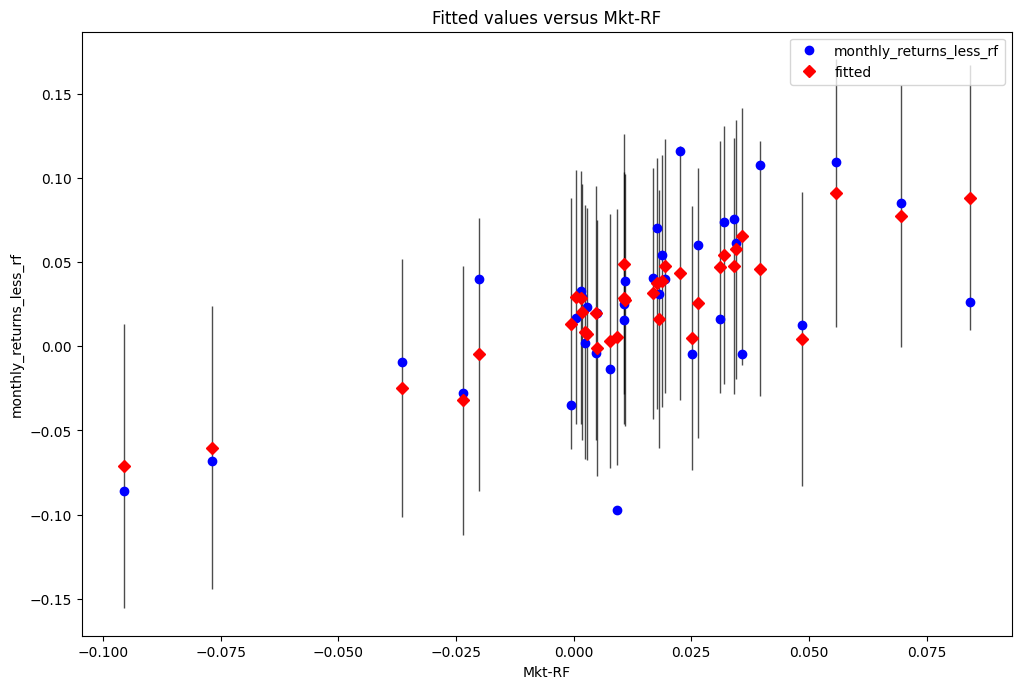

In [32]:
fig, ax = plt.subplots(figsize=(12,8), dpi=100)
sm.graphics.plot_fit(model,1, vlines=True, ax=ax);

In [28]:
y-model.predict(x)

date
2019-04-30   -0.063204
2019-05-31    0.012734
2019-06-30    0.012241
2019-07-31   -0.025759
2019-08-31    0.034264
2019-09-30   -0.062118
2019-10-31   -0.026223
2019-11-30   -0.014391
2019-12-31    0.008093
2020-01-31   -0.001388
2020-02-29   -0.006486
2020-03-31    0.035352
2020-04-30    0.152372
2020-05-31   -0.005310
2020-06-30   -0.032672
2020-07-31   -0.068824
2020-08-31   -0.054330
2020-09-30   -0.063875
2020-10-31   -0.103780
2020-11-30    0.051798
2020-12-31   -0.023841
2021-01-31   -0.052930
2021-02-28    0.077086
2021-03-31   -0.082580
2021-04-30   -0.010874
2021-05-31   -0.029194
2021-06-30    0.112559
2021-07-31   -0.039610
2021-08-31   -0.044821
2021-09-30    0.079108
2021-10-31    0.047715
2021-11-30   -0.016292
2021-12-31   -0.038546
2022-01-31    0.132251
2022-02-28    0.043062
2022-03-31    0.068411
Freq: M, dtype: float64

In [17]:
def rolling_residuals(y, mkt_rf, smb, hml) -> float:
    x = np.stack([mkt_rf, smb, hml]).T
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    
    residuals = y - model.predict(x)
    return residuals[-1]


def idiosync_momentum(res: pd.Series) -> float:
    r = res.iloc[-5:]
  #  print(r)
    sum_r = r.sum()
    std_r = r.std()
    return sum_r/std_r

# def rolling_residuals(ser: pd.Series, **kwargs) -> float:
#    # print(ser.index)
#     df = kwargs['data'].loc[ser.index]
    
#     y = df['monthly_returns_less_rf']
#     x = df[['Mkt-RF', 'SMB', 'HML']]
    
#     x = sm.add_constant(x)
#     model = sm.OLS(y, x).fit()
    
#     residuals = y - model.predict(x)
#     return residuals[-1]

In [18]:
#monthly_combined

In [19]:

monthly_combined['residuals'] = rolling_apply(rolling_residuals, 36, monthly_combined['monthly_returns_less_rf'].values, 
              monthly_combined['Mkt-RF'].values,  monthly_combined['SMB'].values, monthly_combined['HML'].values,)

In [20]:
monthly_combined

,close,monthly_return,Mkt-RF,SMB,HML,RF,monthly_returns_less_rf,residuals
date,,,,,,,,
2006-03-31,24.118149,0.000000,0.0146,0.0345,0.0055,0.0037,-0.003700,NaN
2006-04-30,24.577986,0.019066,0.0073,-0.0143,0.0234,0.0036,0.015466,NaN
2006-05-31,23.872902,-0.028688,-0.0357,-0.0298,0.0239,0.0043,-0.032988,NaN
2006-06-30,24.256100,0.016052,-0.0035,-0.0038,0.0080,0.0040,0.012052,NaN
2006-07-31,23.934217,-0.013270,-0.0078,-0.0399,0.0262,0.0040,-0.017270,NaN
...,...,...,...,...,...,...,...,...
2021-11-30,90.486107,-0.026105,-0.0155,-0.0135,-0.0053,0.0000,-0.026105,0.009547
2021-12-31,96.100952,0.062052,0.0310,-0.0157,0.0323,0.0001,0.061952,0.008521
2022-01-31,94.049896,-0.021343,-0.0624,-0.0587,0.1279,0.0000,-0.021343,0.003317


In [21]:
monthly_combined['idiosync_momentum'] = monthly_combined['residuals'].rolling(15).apply(idiosync_momentum)

In [22]:
monthly_combined.tail(30)

,close,monthly_return,Mkt-RF,SMB,HML,RF,monthly_returns_less_rf,residuals,idiosync_momentum
date,,,,,,,,,
2019-10-31,62.791100,0.026955,0.0206,0.0028,-0.0193,0.0015,0.025455,0.010377,1.103739
2019-11-30,65.407005,0.041660,0.0387,0.0080,-0.0202,0.0012,0.040460,-0.002060,-0.224146
2019-12-31,66.439430,0.015785,0.0277,0.0072,0.0179,0.0014,0.014385,-0.037130,-0.887795
2020-01-31,61.091515,-0.080493,-0.0011,-0.0313,-0.0624,0.0013,-0.081793,-0.012432,-0.653170
2020-02-29,54.269302,-0.111672,-0.0813,0.0103,-0.0379,0.0012,-0.112872,0.016125,-1.191148
2020-03-31,37.793018,-0.303602,-0.1338,-0.0489,-0.1402,0.0012,-0.304802,0.002717,-1.644204
2020-04-30,45.523197,0.204540,0.1365,0.0247,-0.0118,0.0000,0.204540,0.012685,-0.828305
2020-05-31,48.623062,0.068094,0.0558,0.0245,-0.0480,0.0001,0.067994,0.008720,2.477395
2020-06-30,49.501137,0.018059,0.0246,0.0269,-0.0204,0.0001,0.017959,-0.017202,1.749439


In [24]:
monthly_combined['residuals'].iloc[-5:-1].sum()

0.02557827164440307

In [25]:
monthly_combined['residuals'].iloc[-5:-1].std()

0.003097215957372655

In [28]:
monthly_combined['residuals'].iloc[-5:-1].sum()/monthly_combined['residuals'].iloc[-5:-1].std()/2

4.129236061747035

## SKLearn

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [91]:
reg = LinearRegression().fit(x, y)

In [94]:
r2_score(y, reg.predict(x))

0.6400106005462809